EE_Anteil min/max: 0.1452593924696225 0.9120346295077789
count    21887.000000
mean       291.783972
std        131.026734
min         47.942604
25%        179.103847
50%        284.448810
75%        394.011182
max        632.149521
Name: CO2_g_per_kWh_calc, dtype: float64
Pearson r = -0.97   (p = 0.000e+00)


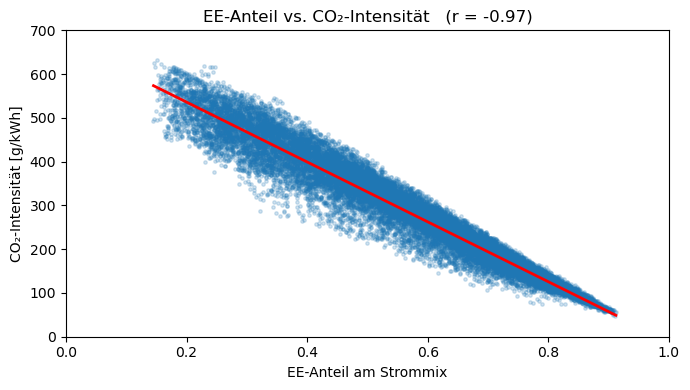

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

csv_path = r"C:\Users\asus\Desktop\Masterarbeit\Realisierte Erzeugung\Strommix_mit_Emissionen_2325_EE_Tonnen.csv"

# 1) Richtig einlesen: DezimalPUNKT, kein thousands
df = pd.read_csv(
    csv_path,
    sep=";", decimal=".",  # <— wichtig!
    parse_dates=["Datum von"], dayfirst=True
).set_index("Datum von")

# 2) Numerik erzwingen
mwh_cols  = [c for c in df.columns if c.endswith("[MWh]")]
tco2_cols = [c for c in df.columns if c.endswith("[t_CO2]")]
num_cols  = mwh_cols + tco2_cols + ["Sum_MWh", "Sum_t_CO2"]

for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 3) Gesamterzeugung selbst neu bilden (robuster als die Datei-Spalte)
df["Sum_MWh_calc"] = df[mwh_cols].sum(axis=1)

# 4) EE-Anteil (0..1)
ee_cols = ["Wind Onshore [MWh]", "Wind Offshore [MWh]",
           "Photovoltaik [MWh]", "Wasserkraft [MWh]", "Biomasse [MWh]","Sonstige Erneuerbare [MWh]"]
df["EE_Anteil"] = df[ee_cols].sum(axis=1) / df["Sum_MWh_calc"]

# 5) CO₂-Intensität korrekt aus Tonnen → g/kWh
df["CO2_g_per_kWh_calc"] = (df["Sum_t_CO2"] * 1000) / df["Sum_MWh_calc"]

# 6) Plausibilitätsfilter
mask = (
    df["Sum_MWh_calc"] > 0
    & df["EE_Anteil"].between(0, 1, inclusive="both")
    & df["CO2_g_per_kWh_calc"].between(0, 1000)
)
d = df.loc[mask, ["EE_Anteil", "CO2_g_per_kWh_calc"]].dropna()

print("EE_Anteil min/max:", d["EE_Anteil"].min(), d["EE_Anteil"].max())
print(d["CO2_g_per_kWh_calc"].describe())

# 7) Pearson + Scatter
r, p = pearsonr(d["EE_Anteil"], d["CO2_g_per_kWh_calc"])
print(f"Pearson r = {r:.2f}   (p = {p:.3e})")

plt.figure(figsize=(7,4))
sns.regplot(
    data=d, x="EE_Anteil", y="CO2_g_per_kWh_calc",
    scatter_kws={"s":6, "alpha":0.20},
    line_kws={"color":"red", "lw":2}, ci=95
)
plt.xlim(0, 1)
plt.ylim(0, max(700, d["CO2_g_per_kWh_calc"].quantile(0.995)))
plt.xlabel("EE-Anteil am Strommix")
plt.ylabel("CO₂-Intensität [g/kWh]")
plt.title(f"EE-Anteil vs. CO₂-Intensität   (r = {r:.2f})")
plt.tight_layout()
plt.show()
